1. Installing required modules

In [1]:
# Install required modules
!pip install datasets
!pip install transformers
!pip install umap-learn

2. Import required modules

In [2]:
# Import required modules
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

3. Mounting google drive for accessing dataset files

In [3]:
# Mounting google drive for accessing dataset files
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4. Creating the dataset

In [4]:
# Creating the dataset
train_file = "/content/drive/MyDrive/2022/College/COMP6321/data/train_dataset_cleaned.csv"
test_file = "/content/drive/MyDrive/2022/College/COMP6321/data/test_dataset_cleaned.csv"

data_files = {"train": train_file, "test": test_file}
class_names = ["negative", "neutral", "positive"]
emotion_features = Features({"id": Value("int64"), "label": ClassLabel(names=class_names), "text": Value("string")})
temp_dataset = load_dataset("csv", data_files=data_files, column_names=["id", "label", "text"], features=emotion_features)

temp_dataset_train_valid = temp_dataset["train"].train_test_split(test_size=0.1)
temp_dataset_train = temp_dataset_train_valid["train"]
temp_dataset_valid = temp_dataset_train_valid["test"]
dataset = DatasetDict({
    "train": temp_dataset_train,
    "valid": temp_dataset_valid,
    "test": temp_dataset["test"]})

# Removing empty text entries
dataset = dataset.filter(lambda example: example["text"] != None)
dataset = dataset.remove_columns("id")

print(dataset)

Using custom data configuration default-197a2373e4fec7aa
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-a9579aad954a79ef.arrow


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25024
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2781
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1301
    })
})


5. Checking the data distribution

In [5]:
# Using pandas for checking the data distribution
dataset.set_format(type="pandas")
train_df = dataset["train"][:]

In [6]:
# Printing the first 5 examples in the train data
def label_int2str(row):
  return dataset["train"].features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,label,text,label_name
0,0,Remember when twitter was a nice place to hang...,negative
1,2,Um..how did this not come up during Barr's con...,positive
2,0,News isn’t fake just because it’s critical o...,negative
3,2,"""Your mental health is more important than you...",positive
4,1,Happy Presidents Day!,neutral


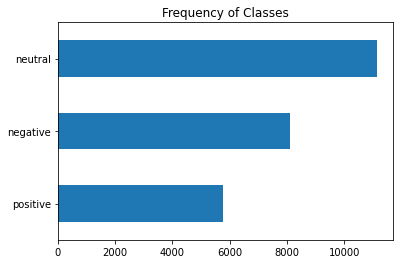

In [7]:
# Displaying the frequency of classes in the training data
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:
# Resetting the dataset format
dataset.reset_format()

6. Tokenization

In [9]:
# Initializing the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
# Defining tokenization function
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
# Applying the tokenize function across all the datasets (train/validation/test)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-c4770fe8dd0f3153.arrow


7. Training a classifier (using feature extraction)

In [12]:
# The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Extracting the last hidden states
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [14]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [15]:
# Extracting hidden states across all dataset splits in one go
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Here, the hidden state corresponding to each input text is available. Next step - create a feature matrix and train a classifier using the hidden states as the input features and the labels as the targets.

8. Creating a feature matrix

In [16]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])

X_train.shape, X_valid.shape

((25024, 768), (2781, 768))

9. Visualizaing the hidden state data before training a classifier

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


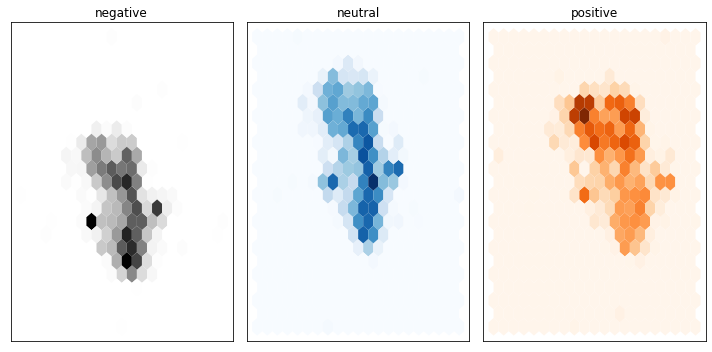

In [17]:
X_scaled = MinMaxScaler().fit_transform(X_train)          # Scaling features to [0, 1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

10. Training a logistic regression classifier using the hidden states and labels

In [18]:
from sklearn.model_selection import cross_val_score

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=(512,), 
                    max_iter=3000,
                    validation_fraction=0.1, 
                    early_stopping=True,
                    verbose=True)
mlp.fit(X_train, y_train)
print("Training accuracy: ", mlp.score(X_train, y_train))
print("Validation dataset accuracy: " , mlp.score(X_valid, y_valid))

Iteration 1, loss = 1.05849986
Validation score: 0.469437
Iteration 2, loss = 1.03897889
Validation score: 0.468638
Iteration 3, loss = 1.03087716
Validation score: 0.478226
Iteration 4, loss = 1.02373710
Validation score: 0.476229
Iteration 5, loss = 1.01906009
Validation score: 0.472233
Iteration 6, loss = 1.01212748
Validation score: 0.451458
Iteration 7, loss = 1.00337370
Validation score: 0.483020
Iteration 8, loss = 0.99424067
Validation score: 0.455054
Iteration 9, loss = 0.98199947
Validation score: 0.472633
Iteration 10, loss = 0.97390447
Validation score: 0.479425
Iteration 11, loss = 0.95659881
Validation score: 0.482221
Iteration 12, loss = 0.94376066
Validation score: 0.482221
Iteration 13, loss = 0.92507026
Validation score: 0.498202
Iteration 14, loss = 0.91032293
Validation score: 0.495406
Iteration 15, loss = 0.88596212
Validation score: 0.491011
Iteration 16, loss = 0.87124032
Validation score: 0.495406
Iteration 17, loss = 0.84828792
Validation score: 0.506592
Iterat

11. Print the confusion matrix for the dummy classifier

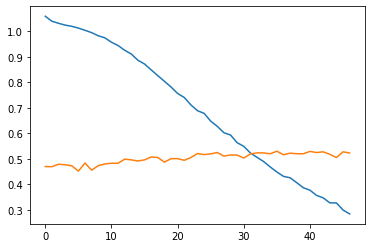

In [46]:
plt.plot(mlp.loss_curve_)
plt.plot(mlp.validation_scores_)

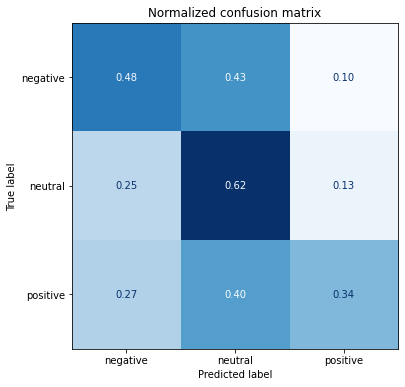

In [47]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = mlp.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [48]:
from sklearn.metrics import classification_report

mlp_report = classification_report(y_valid, y_preds, target_names=labels)
print(mlp_report)

              precision    recall  f1-score   support

    negative       0.47      0.48      0.48       901
     neutral       0.54      0.62      0.58      1227
    positive       0.47      0.34      0.39       653

    accuracy                           0.51      2781
   macro avg       0.50      0.48      0.48      2781
weighted avg       0.50      0.51      0.50      2781



12. Save model

In [49]:
from joblib import dump, load

mlp_save_filename = "/content/drive/MyDrive/2022/College/COMP6321/saved_models/mlp.joblib"
dump(mlp, mlp_save_filename)

['/content/drive/MyDrive/2022/College/COMP6321/saved_models/mlp.joblib']

13. Load model

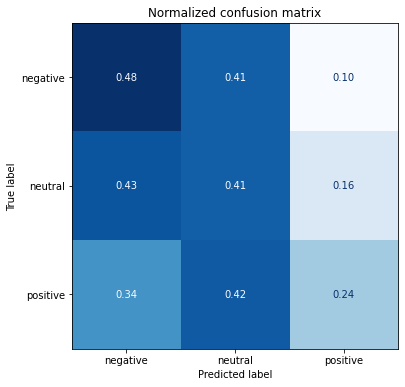

In [50]:
loaded_mlp = load(mlp_save_filename)

X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_test = np.array(dataset_hidden["test"]["label"])
y_preds_t = loaded_mlp.predict(X_test)
plot_confusion_matrix(y_preds_t, y_test, labels)

In [51]:
mlp_report = classification_report(y_valid, y_preds, target_names=labels, output_dict=True)
print(mlp_report)


{'negative': {'precision': 0.4740331491712707, 'recall': 0.47613762486126526, 'f1-score': 0.47508305647840526, 'support': 901}, 'neutral': {'precision': 0.5436479772888574, 'recall': 0.6242868785656072, 'f1-score': 0.5811836115326252, 'support': 1227}, 'positive': {'precision': 0.4689507494646681, 'recall': 0.33537519142419603, 'f1-score': 0.39107142857142857, 'support': 653}, 'accuracy': 0.5084501977705861, 'macro avg': {'precision': 0.4955439586415988, 'recall': 0.4785998982836895, 'f1-score': 0.482446032194153, 'support': 2781}, 'weighted avg': {'precision': 0.503554395878163, 'recall': 0.5084501977705861, 'f1-score': 0.5021689205662413, 'support': 2781}}
